In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

C:\Users\johbr\AppData\Local\Temp\ipykernel_17948\138741423.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
# import data
df = pd.read_csv("../resources/ames_housing_data.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# display numerical features
df_num = df.select_dtypes(include=["float64", "int64"])
df_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


## Data Preprocessing

In [4]:
# fill missing values with the mean for each numerical feature
df = df.fillna(df_num.mean())

In [5]:
# drop 'Id'
df = df.drop("Id", axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# drop outliers (rooms with more than 4000 square feet)
df = df[df.GrLivArea <= 4000]

In [7]:
# get_dummies for categorical data
dummies = pd.get_dummies(df)
dummies.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,False,False,False,True,False,False,False,False,True,False
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,False,False,False,True,False,False,False,False,True,False
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,False,False,False,True,False,False,False,False,True,False
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,False,False,False,True,True,False,False,False,False,False
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,False,False,False,True,False,False,False,False,True,False


SalePrice                1.000000
OverallQual              0.800858
GrLivArea                0.720516
GarageCars               0.649256
TotalBsmtSF              0.646584
GarageArea               0.636964
1stFlrSF                 0.625235
FullBath                 0.559048
BsmtQual_Ex              0.548645
TotRmsAbvGrd             0.537462
YearBuilt                0.535279
YearRemodAdd             0.521428
Foundation_PConc         0.505863
KitchenQual_Ex           0.495110
GarageYrBlt              0.481486
MasVnrArea               0.476449
Fireplaces               0.466765
ExterQual_Gd             0.466282
ExterQual_Ex             0.455788
HeatingQC_Ex             0.441402
BsmtFinType1_GLQ         0.436395
Neighborhood_NridgHt     0.419524
GarageFinish_Fin         0.419276
BsmtFinSF1               0.395923
SaleType_New             0.377228
SaleCondition_Partial    0.371494
FireplaceQu_Gd           0.359029
MasVnrType_Stone         0.348909
KitchenQual_Gd           0.342164
GarageType_Att

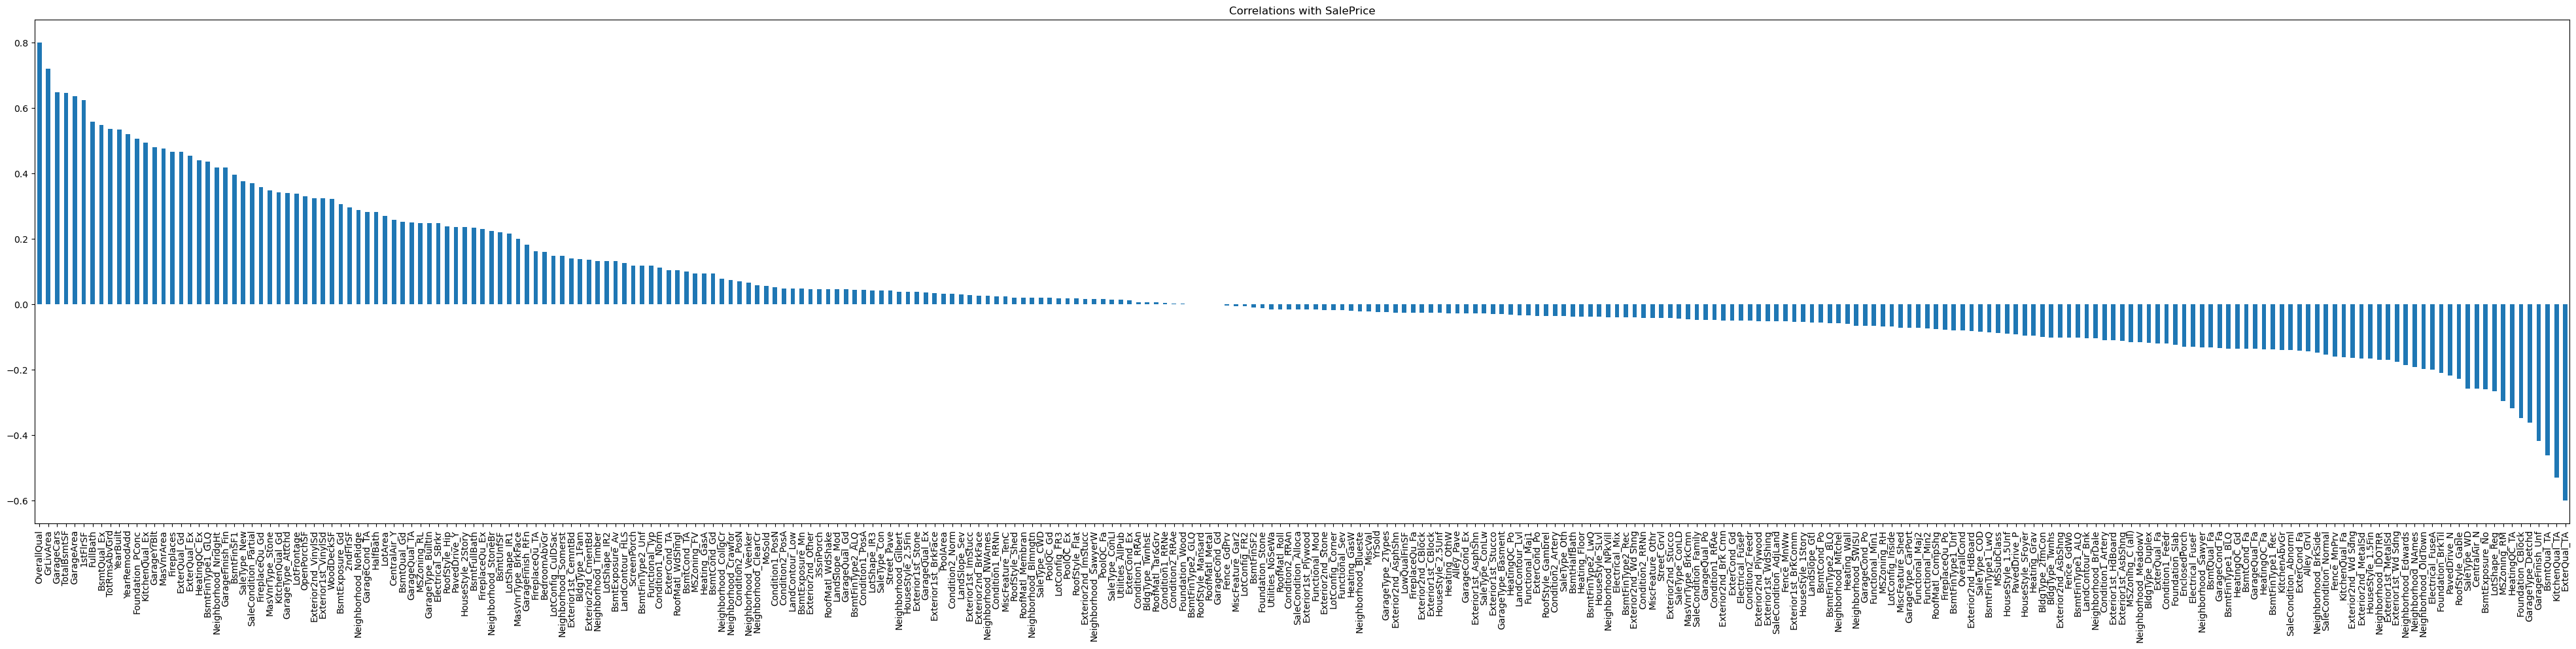

<Figure size 4000x1000 with 0 Axes>

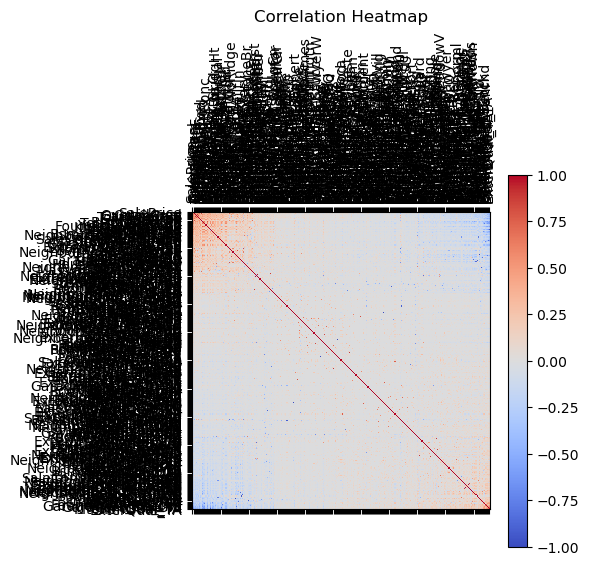

In [11]:
# calculate correlations
correlations = dummies.corr()['SalePrice'].sort_values(ascending=False)

# disable pandas display truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# print correlations
print(correlations)

# reset pandas truncation
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

# plot correlations bar chart
plt.figure(figsize=(50, 10))
correlations.drop('SalePrice').plot(kind='bar')
plt.title('Correlations with SalePrice')
plt.show()

# convert correlations to a DataFrame for the heatmap
correlations_df = dummies[correlations.index].corr()

# plot a heatmap of correlations
plt.figure(figsize=(40, 10))
plt.matshow(correlations_df, cmap='coolwarm')
plt.xticks(range(len(correlations_df.columns)), correlations_df.columns, rotation=90)
plt.yticks(range(len(correlations_df.columns)), correlations_df.columns)
plt.colorbar()
plt.title('Correlation Heatmap')
plt.show()

In [9]:
# split data into target and features
y = dummies.SalePrice.values
X = dummies.drop(columns="SalePrice").values

# split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

# scale the data
scaler = StandardScaler()

# fit the scaler only to the training data
# to prevent data leakage (e.g., mean and standard deviation not modified by X_test and X_val)
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# df just to plot the data immediately below
scaled_df = pd.DataFrame(X_train, columns=dummies.drop(columns="SalePrice").columns)

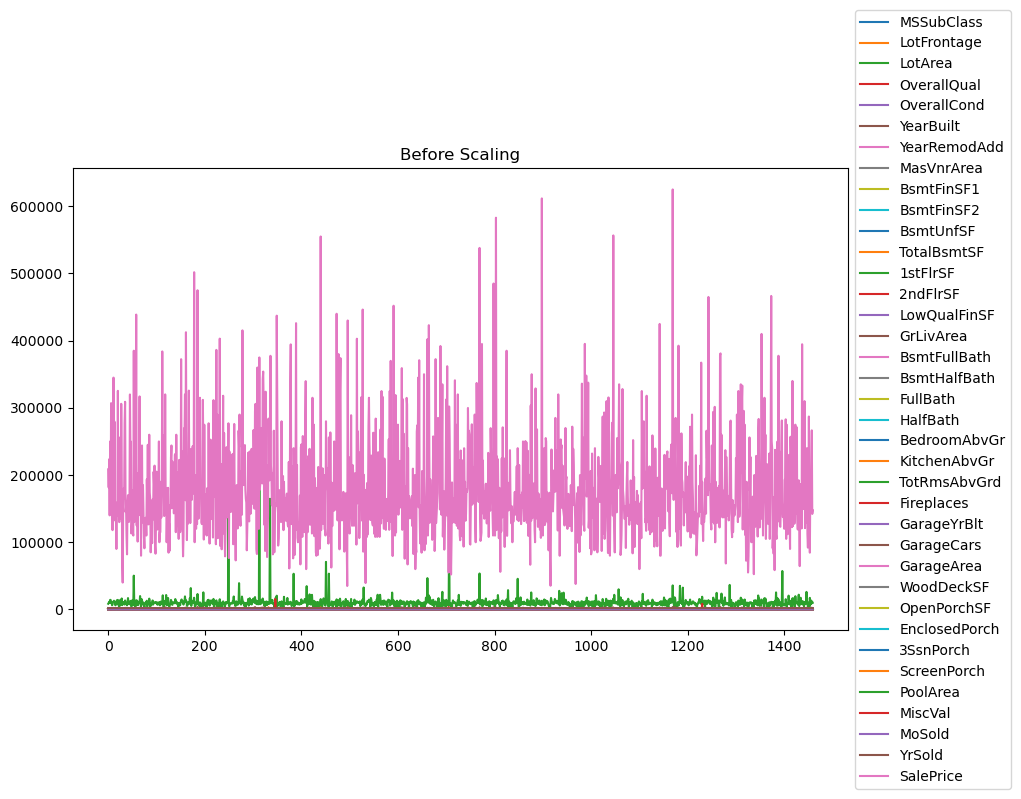

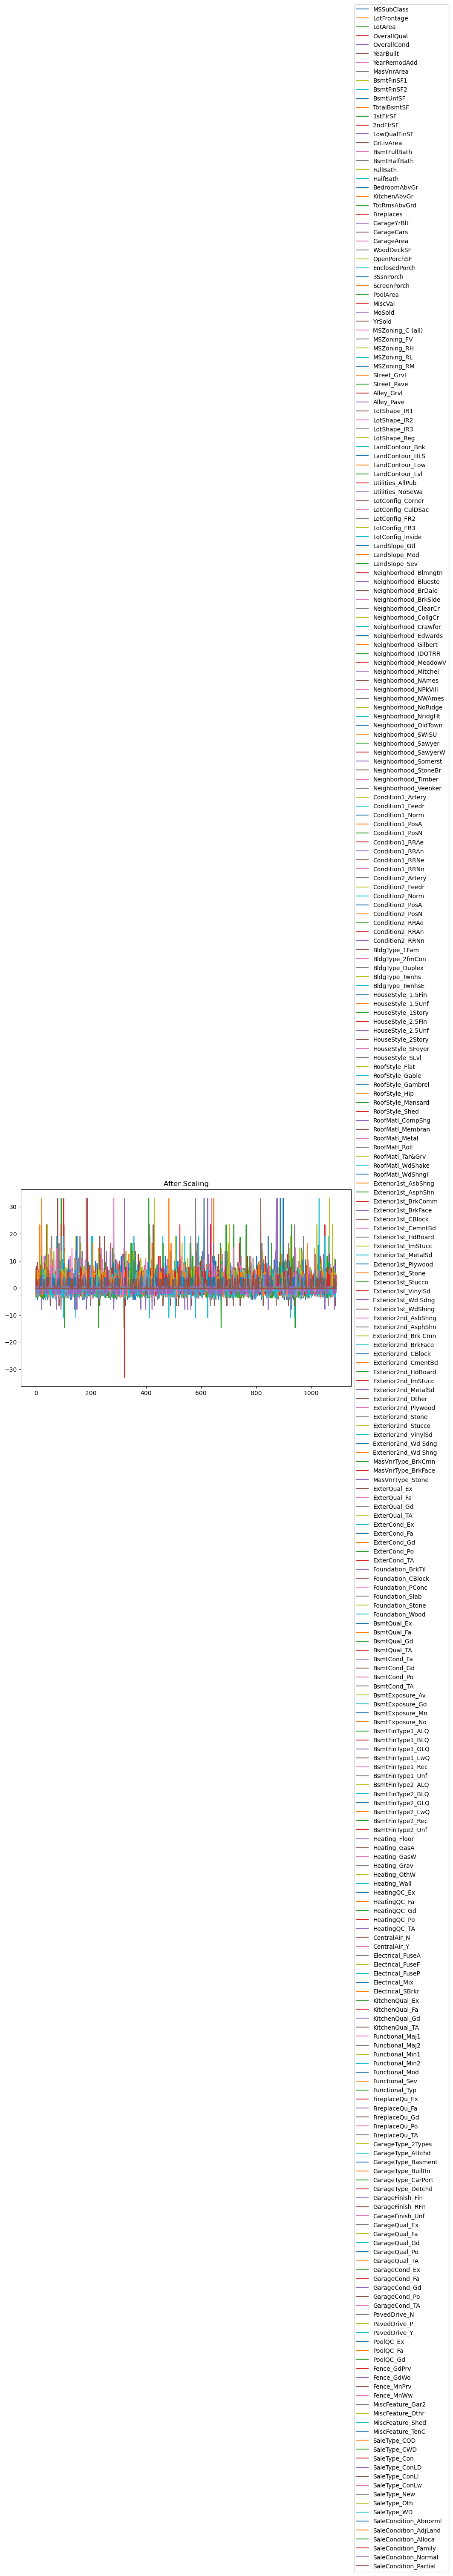

In [12]:
# plot data before scaling
dummies.plot(title='Before Scaling', figsize=(10, 6))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# after scaling
scaled_df.plot(title='After Scaling', figsize=(10, 6))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

## Compile, Train, Evaluate the Model

In [13]:
# build keras-tuner function
def build_model(hp):
    nn_test = tf.keras.models.Sequential()

    # adds a range of 1 to 5 dense layers, allowable number of neurons (adjust based on features), activation functions
    for i in range(hp.Int("num_layers", min_value=1, max_value=5, step=1)):
        nn_test.add(
            tf.keras.layers.Dense(
                units=hp.Int(f"layer{i}", min_value=50, max_value=600, step=50),
                input_dim=len(X_train[0]),
                activation=hp.Choice(f"activation{i}", values=["relu", "tanh", "LeakyReLU"])
            )
        )

    # add final layer
    nn_test.add(tf.keras.layers.Dense(units=1, activation="linear"))

    # compile the model
    nn_test.compile(
        loss="mean_absolute_error",
        optimizer="adam",
        metrics=["mae"],
    )

    return nn_test

In [14]:

# define tuner / call the build_model function
tuner = RandomSearch(build_model, objective="mae", max_trials=10, overwrite=True)

# run the damn thing
tuner.search(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
)

Trial 10 Complete [00h 00m 20s]
mae: 3208.166015625

Best mae So Far: 3208.166015625
Total elapsed time: 00h 03m 17s


In [15]:
# summary of results
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="mae", direction="min")

Trial 09 summary
Hyperparameters:
num_layers: 5
layer0: 250
activation0: tanh
layer1: 400
activation1: tanh
layer2: 300
activation2: relu
layer3: 50
activation3: relu
layer4: 150
activation4: LeakyReLU
Score: 3208.166015625

Trial 00 summary
Hyperparameters:
num_layers: 4
layer0: 600
activation0: relu
layer1: 50
activation1: relu
layer2: 50
activation2: relu
layer3: 50
activation3: relu
Score: 4213.7021484375

Trial 03 summary
Hyperparameters:
num_layers: 5
layer0: 350
activation0: tanh
layer1: 100
activation1: tanh
layer2: 300
activation2: LeakyReLU
layer3: 550
activation3: relu
layer4: 50
activation4: relu
Score: 4712.0537109375

Trial 08 summary
Hyperparameters:
num_layers: 3
layer0: 50
activation0: tanh
layer1: 200
activation1: LeakyReLU
layer2: 350
activation2: LeakyReLU
layer3: 350
activation3: LeakyReLU
layer4: 600
activation4: LeakyReLU
Score: 6190.44580078125

Trial 02 

In [16]:
# get the best hyperparameters from the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# build that model
nn = tuner.hypermodel.build(best_hps)

# add early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# train the model
fit_model = nn.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)

Epoch 1/100
35/35 [==============================] - 2s 9ms/step - loss: 182161.2188 - mae: 182161.2188 - val_loss: 173380.5469 - val_mae: 173380.5469
Epoch 2/100
35/35 [==============================] - 0s 4ms/step - loss: 173535.6250 - mae: 173535.6250 - val_loss: 145564.5000 - val_mae: 145564.5000
Epoch 3/100
35/35 [==============================] - 0s 4ms/step - loss: 97788.0703 - mae: 97788.0703 - val_loss: 48749.7266 - val_mae: 48749.7266
Epoch 4/100
35/35 [==============================] - 0s 4ms/step - loss: 44135.6641 - mae: 44135.6641 - val_loss: 40287.8867 - val_mae: 40287.8867
Epoch 5/100
35/35 [==============================] - 0s 4ms/step - loss: 42743.7539 - mae: 42743.7539 - val_loss: 41311.5039 - val_mae: 41311.5039
Epoch 6/100
35/35 [==============================] - 0s 4ms/step - loss: 41958.2031 - mae: 41958.2031 - val_loss: 41291.2656 - val_mae: 41291.2656
Epoch 7/100
35/35 [==============================] - 0s 4ms/step - loss: 41938.1133 - mae: 41938.1133 - val_lo

In [17]:
print("Best Hyperparameters:")
print(best_hps.values)

Best Hyperparameters:
{'num_layers': 5, 'layer0': 250, 'activation0': 'tanh', 'layer1': 400, 'activation1': 'tanh', 'layer2': 300, 'activation2': 'relu', 'layer3': 50, 'activation3': 'relu', 'layer4': 150, 'activation4': 'LeakyReLU'}


In [18]:
# summarize final model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 250)               71750     
                                                                 
 dense_7 (Dense)             (None, 400)               100400    
                                                                 
 dense_8 (Dense)             (None, 300)               120300    
                                                                 
 dense_9 (Dense)             (None, 50)                15050     
                                                                 
 dense_10 (Dense)            (None, 150)               7650      
                                                                 
 dense_11 (Dense)            (None, 1)                 151       
                                                                 
Total params: 315301 (1.20 MB)
Trainable params: 31530

In [19]:
# print weights, just because
all_weights = nn.get_weights()
for i, layer_weights in enumerate(all_weights):
    print(f"Layer {i} Weights:")
    print(layer_weights)

Layer 0 Weights:
[[-1.22862898e-01  1.05221167e-01  1.43275522e-02 ... -1.26031399e-01
   6.13293163e-02  4.24949899e-02]
 [ 7.50849620e-02 -1.60642967e-01 -1.06225975e-01 ... -8.26388001e-02
  -6.06017746e-02  6.03489801e-02]
 [ 4.34329957e-02  4.69476841e-02 -7.86440149e-02 ...  2.60761585e-02
  -1.17050493e-02  3.20318282e-01]
 ...
 [-3.00052259e-02  7.35338554e-02 -3.60131008e-03 ...  1.28154214e-02
   1.32234469e-01  1.02387428e-01]
 [-4.46592085e-02  1.74742788e-02 -8.82918015e-02 ... -9.87706035e-02
   3.83895524e-02 -4.36450578e-02]
 [ 1.82115421e-01 -1.19912721e-01  7.33831694e-05 ... -3.95553559e-03
  -1.76602334e-03  1.04010977e-01]]
Layer 1 Weights:
[-2.89039351e-02 -9.87903923e-02 -2.14633737e-02  1.32426664e-01
  3.15714860e-03  4.42787595e-02  5.48939779e-02  6.85603693e-02
 -7.74055570e-02  6.84894696e-02  5.21800388e-03  1.56487264e-02
  2.07377132e-03  1.52101824e-02 -7.46181831e-02  4.16985713e-02
 -2.02814311e-01  1.37606235e-02  3.12650613e-02 -4.49797474e-02
 -9.1

In [20]:
# revert scaled data for testing predictions
y_test_pred=nn.predict(X_test)

6/6 [==============================] - 0s 2ms/step


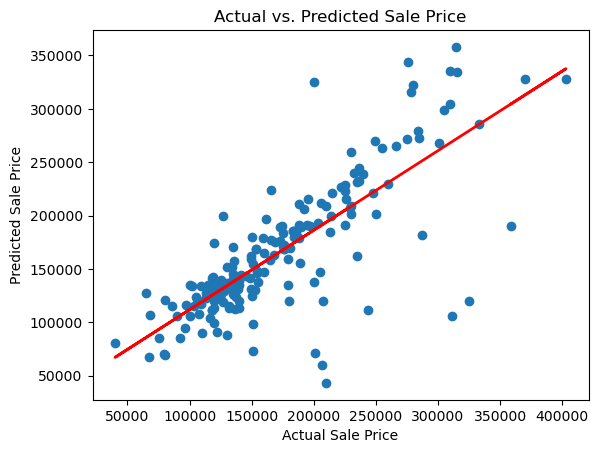

In [21]:
# Scatter plot for actual vs. predicted Sale Price
plt.scatter(y_test, y_test_pred.flatten())
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs. Predicted Sale Price")

# Add a line of best fit
fit = np.polyfit(y_test.flatten(), y_test_pred.flatten(), 1)
line = np.poly1d(fit)
plt.plot(y_test.flatten(), line(y_test.flatten()), color="red", linewidth=2)

plt.show()

In [22]:
# print the r_squared
print(f"R-squared: {r2_score(y_test, y_test_pred)}")

# and other metrics
print(f"Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")
print(f"Mean Percentage Error: {np.mean((y_test - y_test_pred) / y_test) * 100}")

R-squared: 0.5736770989592511
Mean Squared Error: 1850728277.0769181
Mean Absolute Error: 24900.125472184067
Mean Percentage Error: -10.929041917614963


In [23]:
# predict a baseline
# essentially, set every value to the mean and create a fake list of predictions
# compare to above model's predictions
baseline_prediction = y_train.mean()

# create array of baseline predictions with the length of y_test
baseline_predictions = [baseline_prediction] * len(y_test)

print(f"Baseline R-squared: {r2_score(y_test, baseline_predictions)}")
print(
    f"Baseline Mean Squared Error: {mean_squared_error(y_test, baseline_predictions)}"
)
print(
    f"Baseline Mean Absolute Error: {mean_absolute_error(y_test, baseline_predictions)}"
)
print(
    f"Mean Percentage Error: {np.mean((y_test - baseline_predictions) / y_test) * 100}"
)

Baseline R-squared: -0.020610114208674313
Baseline Mean Squared Error: 4430613494.197803
Baseline Mean Absolute Error: 54345.8021978022
Mean Percentage Error: -21.726878869297774


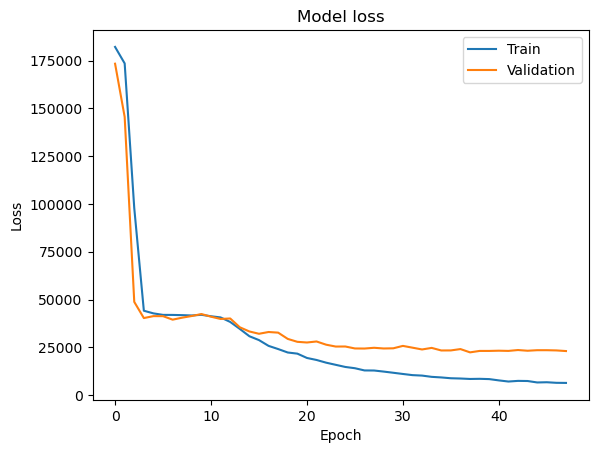

In [24]:
# plot training & validation loss values
# hopefully these both drop quickly and stabilize
# if not...
# validation loss up and training down? overfitting
# training and validation high? underfitting
plt.plot(fit_model.history["loss"])
plt.plot(fit_model.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

6/6 [==============================] - 0s 2ms/step


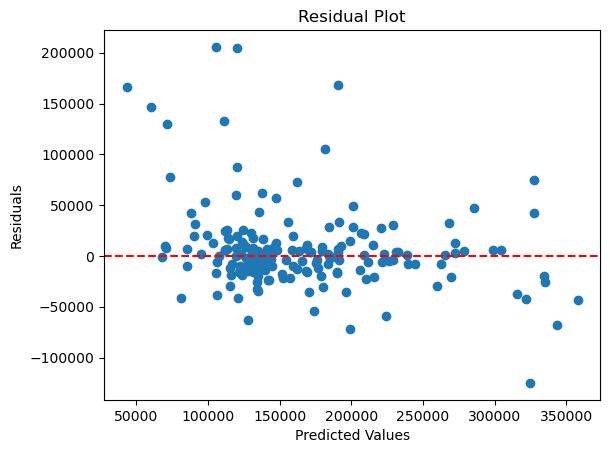

In [25]:
# residual plot
# difference between actual and predicted values
# you want there to be a rnadom distribution around the red line, zero
residuals = y_test - nn.predict(X_test).flatten()
plt.scatter(nn.predict(X_test).flatten(), residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

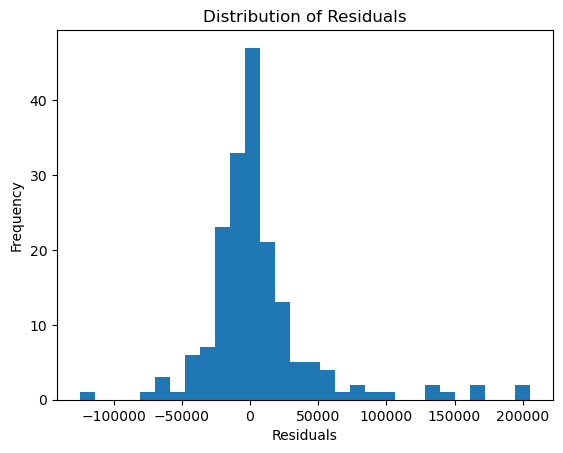

In [26]:
# distribution of residuals
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

In [27]:
# plot the learning curve?